In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

In [3]:
images, labels = next(iter(dataloader))
print(torch.min(images), torch.max(images))
print(images[0].shape)

tensor(0.) tensor(1.)
torch.Size([1, 28, 28])


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),       # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),          # N, 128 -> N, 64
            nn.ReLU(),
            nn.Linear(64, 12),          # N, 64 -> N, 12
            nn.ReLU(),
            nn.Linear(12, 3),            # N, 12 -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),            # N, 12 -> N, 3
            nn.ReLU(),
            nn.Linear(12, 64),           # N, 12 -> N, 64
            nn.ReLU(),
            nn.Linear(64, 128),         # N, 64 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 28*28),       # N, 128 -> N, 784
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# NOTE: if input images are in range [-1, 1] -> nn.Tanh (often after normalization in transform)

In [5]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [6]:
EPOCHS = 10
outputs = []

for epoch in range(EPOCHS):
    for (im, _) in dataloader:
        im = im.reshape(-1, 28*28)
        reconstructed_im = model(im)
        loss = criterion(reconstructed_im, im)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}\tLoss: {loss.item():.4f}")
    outputs.append((epoch, im, reconstructed_im))

Epoch: 1	Loss: 0.0500
Epoch: 2	Loss: 0.0438
Epoch: 3	Loss: 0.0396
Epoch: 4	Loss: 0.0378
Epoch: 5	Loss: 0.0332
Epoch: 6	Loss: 0.0352
Epoch: 7	Loss: 0.0363
Epoch: 8	Loss: 0.0356
Epoch: 9	Loss: 0.0362
Epoch: 10	Loss: 0.0355


/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDepreca

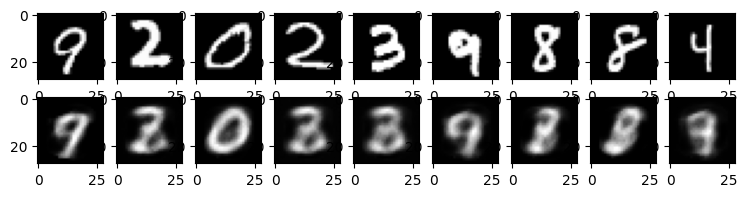

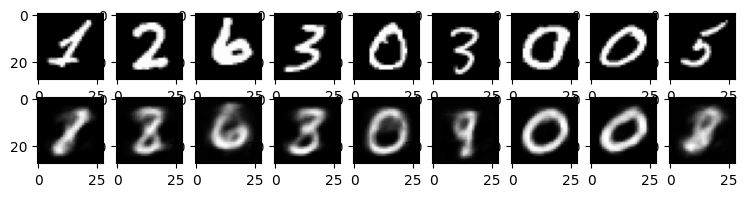

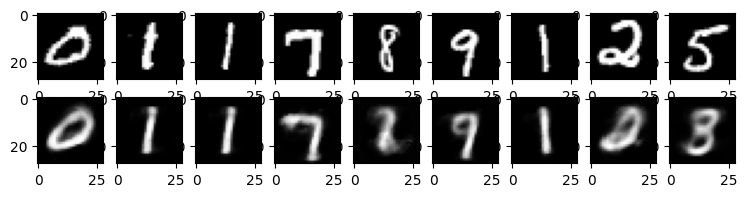

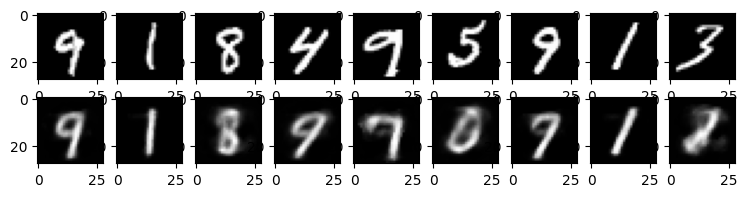

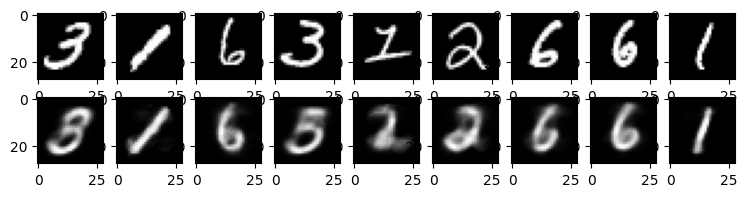

In [7]:
for k in range(0, EPOCHS, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    ims = outputs[k][1].detach().numpy()
    reconstructed_ims = outputs[k][2].detach().numpy()

    for i, item in enumerate(ims):
        if i>=9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructed_ims):
        if i>=9:break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

Using a CNN

In [16]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),       # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),      # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                           # N, 64, 1, 1
        )

        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),              # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# NOTE: nn.MaxPool2d -> nn.MaxUnpool2d if and when using MaxPool2d

In [17]:
model = ConvAutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [18]:
EPOCHS = 10
outputs = []

for epoch in range(EPOCHS):
    for (im, _) in dataloader:
        reconstructed_im = model(im)
        loss = criterion(reconstructed_im, im)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}\tLoss: {loss.item():.4f}")
    outputs.append((epoch, im, reconstructed_im))

Epoch: 1	Loss: 0.0100
Epoch: 2	Loss: 0.0056
Epoch: 3	Loss: 0.0041
Epoch: 4	Loss: 0.0037
Epoch: 5	Loss: 0.0030
Epoch: 6	Loss: 0.0042
Epoch: 7	Loss: 0.0026
Epoch: 8	Loss: 0.0030
Epoch: 9	Loss: 0.0027
Epoch: 10	Loss: 0.0031


/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDepreca

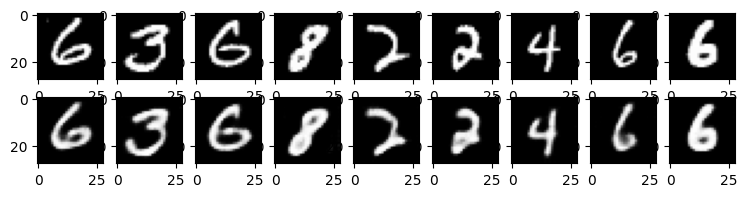

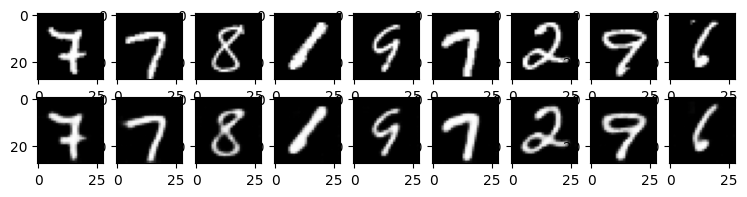

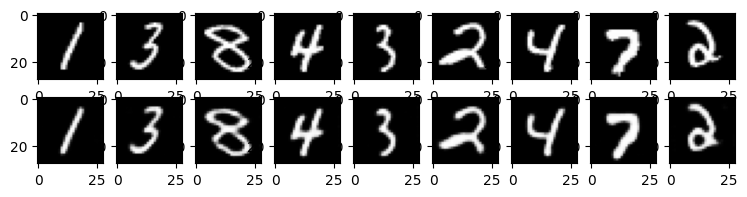

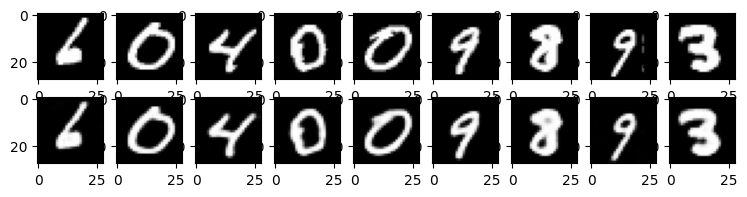

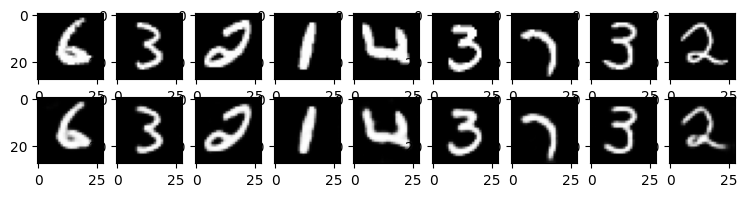

In [19]:
for k in range(0, EPOCHS, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    ims = outputs[k][1].detach().numpy()
    reconstructed_ims = outputs[k][2].detach().numpy()

    for i, item in enumerate(ims):
        if i>=9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructed_ims):
        if i>=9:break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

Variational AutoEncoder (Linear)

In [74]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: outputs mean and log-variance
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(12, 3)
        self.fc_logvar = nn.Linear(12, 3)

        # Decoder: Takes latent vector z and reconstructs image
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        z = self.reparameterize(mu, logvar)

        decoded = self.decoder(z)
        return decoded, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    

def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction="sum")
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

In [75]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [76]:
EPOCHS = 25
outputs = []

for epoch in range(EPOCHS):
    for (im, _) in dataloader:
        im = im.reshape(-1, 28*28)
        reconstructed_im, mu, logvar = model(im)
        loss = vae_loss(reconstructed_im, im, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}\tLoss: {loss.item():.4f}")
    outputs.append((epoch, im, reconstructed_im))

Epoch: 1	Loss: 4807.2744
Epoch: 2	Loss: 5056.1313
Epoch: 3	Loss: 4837.4771
Epoch: 4	Loss: 4529.5884
Epoch: 5	Loss: 4145.9102
Epoch: 6	Loss: 4147.5635
Epoch: 7	Loss: 4574.2769
Epoch: 8	Loss: 4956.8130
Epoch: 9	Loss: 4379.9258
Epoch: 10	Loss: 4658.1333
Epoch: 11	Loss: 4545.5449
Epoch: 12	Loss: 4243.7061
Epoch: 13	Loss: 4359.2314
Epoch: 14	Loss: 4484.9810
Epoch: 15	Loss: 4037.6724
Epoch: 16	Loss: 3975.1289
Epoch: 17	Loss: 4253.4248
Epoch: 18	Loss: 4448.3320
Epoch: 19	Loss: 4012.8765
Epoch: 20	Loss: 4800.9238
Epoch: 21	Loss: 3971.1587
Epoch: 22	Loss: 4200.4302
Epoch: 23	Loss: 4306.9204
Epoch: 24	Loss: 4189.0938
Epoch: 25	Loss: 4386.0864


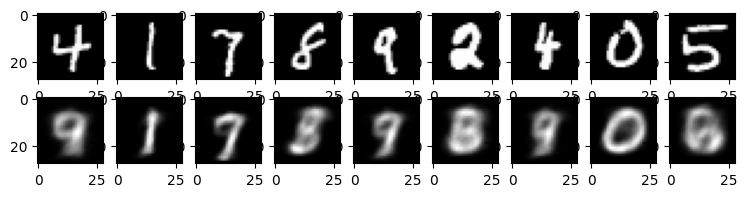

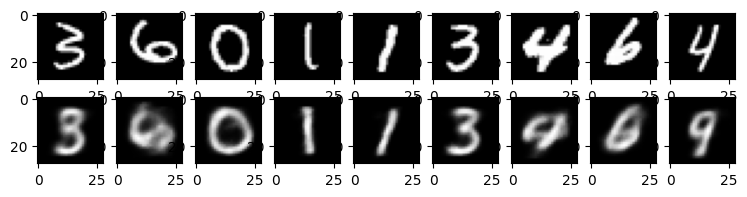

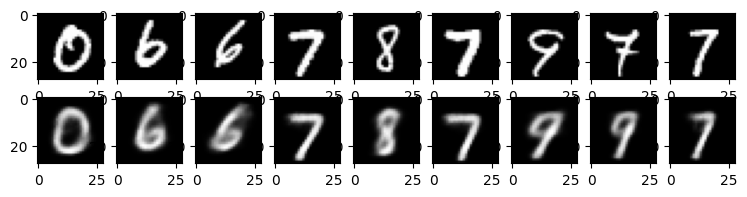

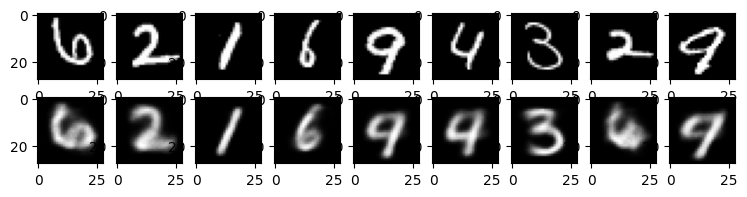

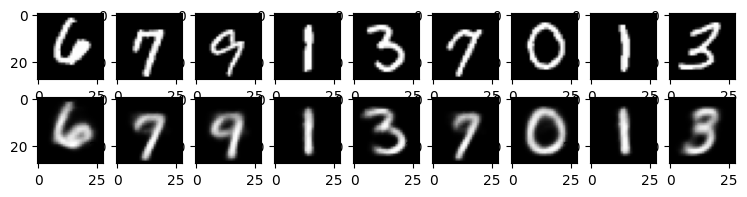

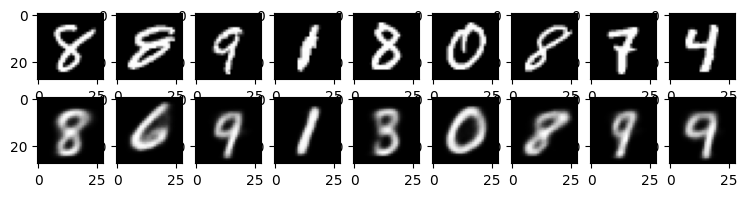

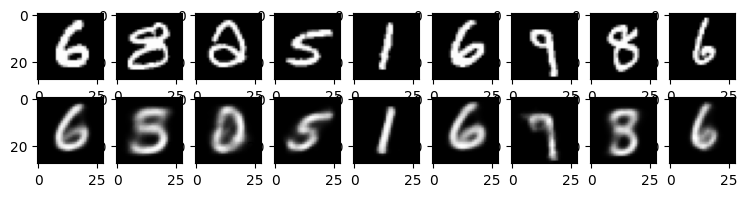

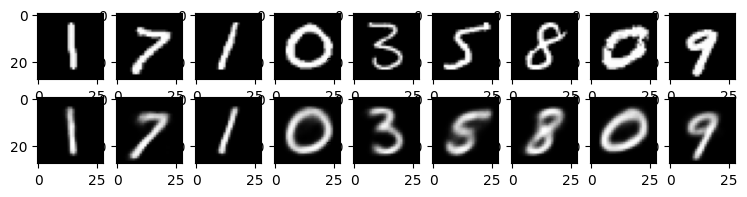

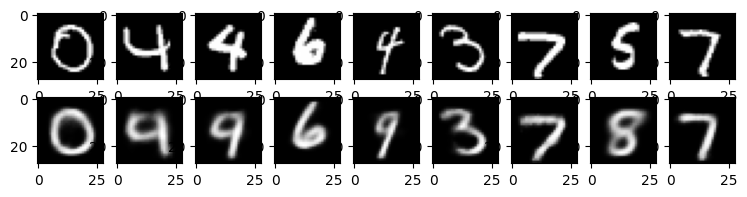

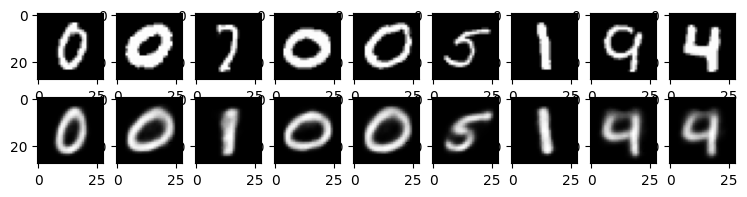

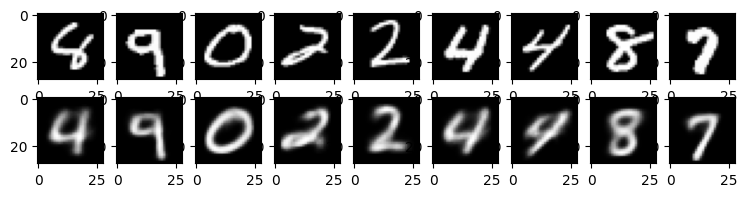

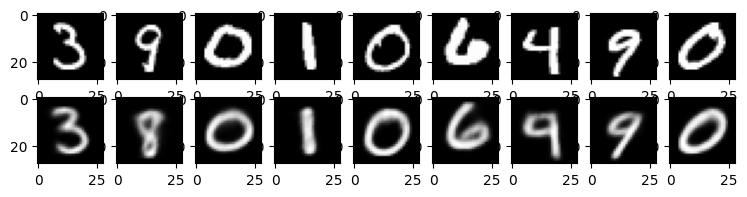

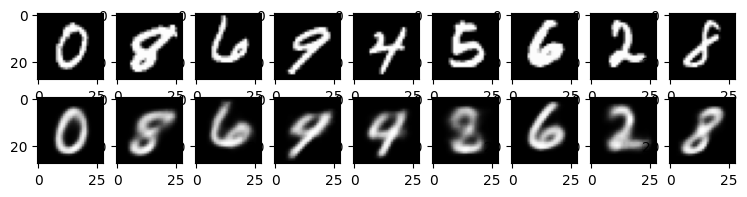

In [78]:
for k in range(0, EPOCHS, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    ims = outputs[k][1].detach().numpy()
    reconstructed_ims = outputs[k][2].detach().numpy()

    for i, item in enumerate(ims):
        if i>=9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructed_ims):
        if i>=9:break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

CNN VAE

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),  # N, 64, 1, 1
        )

        # Latent space
        self.fc_mu = nn.Linear(64, 20)        # Mean of latent space
        self.fc_logvar = nn.Linear(64, 20)   # Log-variance of latent space
        self.fc_z = nn.Linear(20, 64)        # Project latent vector back to decoder

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)   # Random normal noise
        return mu + eps * std

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)  # Output: N, 64, 1, 1
        encoded = encoded.view(encoded.size(0), -1)  # Flatten: N, 64

        # Get mean and log-variance for latent space
        mu = self.fc_mu(encoded)       # Mean: N, 20
        logvar = self.fc_logvar(encoded)  # Log-variance: N, 20

        # Reparameterize to get latent vector z
        z = self.reparameterize(mu, logvar)

        # Decode the latent vector
        z = self.fc_z(z)  # Project z back to 64 for the decoder
        z = z.view(z.size(0), 64, 1, 1)  # Reshape for ConvTranspose2d
        decoded = self.decoder(z)  # Reconstruct the input

        return decoded, mu, logvar


# Loss function
def vae_loss(reconstructed_x, x, mu, logvar):
    """
    VAE loss = BCE + KL Divergence
    """
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum') / x.size(0)  # Normalize BCE loss by batch size
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)  # Normalize KL loss by batch size
    return BCE + KL

In [86]:
model = ConvVAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [87]:
EPOCHS = 10
outputs = []

for epoch in range(EPOCHS):
    for (im, _) in dataloader:
        # im = im.reshape(-1, 28*28)
        reconstructed_im, mu, logvar = model(im)
        loss = vae_loss(reconstructed_im, im, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}\tLoss: {loss.item():.4f}")
    outputs.append((epoch, im, reconstructed_im))

Epoch: 1	Loss: 121.3380
Epoch: 2	Loss: 107.8121
Epoch: 3	Loss: 101.5499
Epoch: 4	Loss: 105.8231
Epoch: 5	Loss: 96.6885
Epoch: 6	Loss: 108.4026
Epoch: 7	Loss: 101.3968
Epoch: 8	Loss: 108.5304
Epoch: 9	Loss: 105.4311
Epoch: 10	Loss: 111.7835


/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDepreca

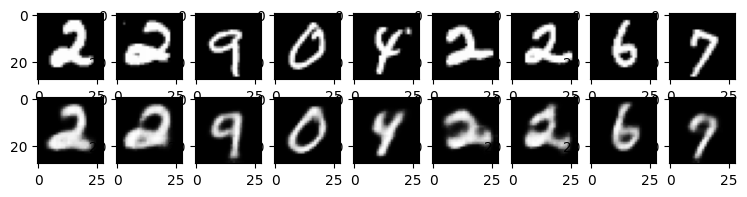

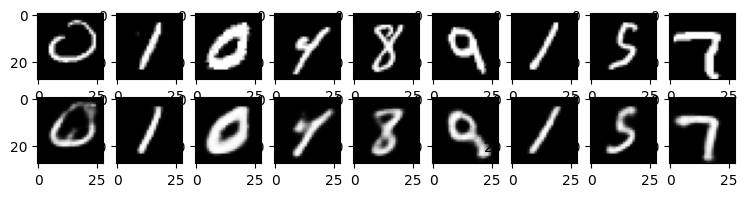

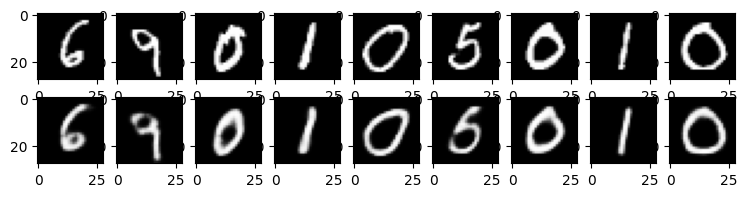

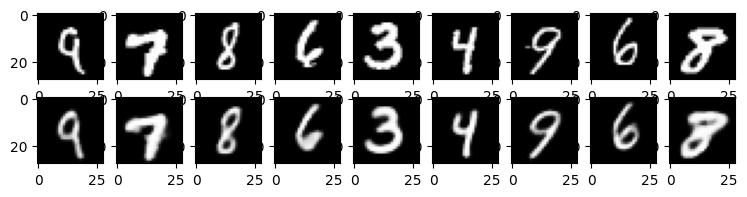

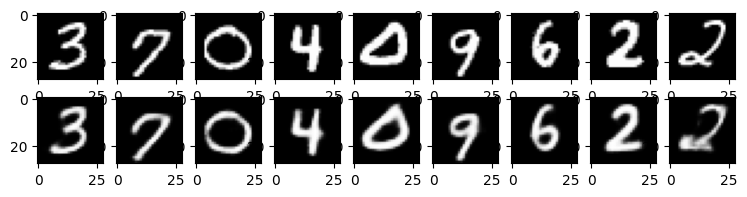

In [88]:
for k in range(0, EPOCHS, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    ims = outputs[k][1].detach().numpy()
    reconstructed_ims = outputs[k][2].detach().numpy()

    for i, item in enumerate(ims):
        if i>=9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructed_ims):
        if i>=9:break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])